# The Second Villain: Feature Leakage

The aim of train-test split and cross-validation is to make sure that the model is tested on data about which it has absolutely no information during training.
Absolutely no information. But, unfortunately, information about the target can easily "leak" into the training process, especially if we already have access to the testing data at the time of training, as in the case of cross-validation.

The most typical form of information leakage is employing a common preprocessing step on all features that utilizes information from all subjects (both train and test).

A vey characteristic example is when we do feature selection on the whole dataset, including the data that we will test on, i.e before the train-test split or outside of the cross-validation loop. This way we will for sure end up with feature leakage and obtain overly optimistic estimates of prediction accuracy.

Let's quickly illustrate the problem with some code!

In [48]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import LeaveOneOut, KFold
import seaborn as sns

To make sure there is no chance at all for the model to predict, we will take random data.

MAE =  9.304656436978659 years


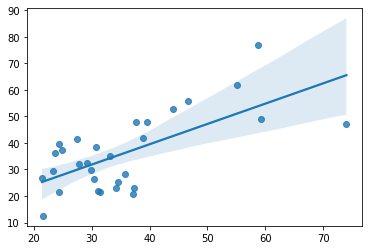

In [49]:
n_sub = 30
p_features = 100

# here we simulate random features - guaranteed to be independent of the target
rng = np.random.default_rng(seed = 42)
df_random = pd.DataFrame(rng.normal(loc=0, scale=1, size=(n_sub, p_features)))

# we load some real age data
age = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv").loc[:n_sub-1,['Age']].values.ravel()

##########################################################################################################################
## DO NOT TRY THIS AT HOME: here we select the features *globally*, before the train test split, to demonstrate leakage  #
best_features = SelectKBest(k=30).fit_transform(y=age, X=df_random) # NEVER DO THIS OUTSIDE A CV                         #
##########################################################################################################################

# cross-validation with a Rideg model
cv_predictions = cross_val_predict(estimator=Ridge(0.1), y=age, X=best_features, cv=LeaveOneOut())
sns.regplot(x=age, y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=age, y_pred=cv_predictions), 'years')

As expected: if we do not select the best features on independnet datam, but instead on the sample which is also used for training (e.g. on the whole sample before the cross-validation), we do [double-dipping](https://en.wikipedia.org/wiki/Circular_analysis).


While selecting best features in a circular way is a pretty obvious case of target leakage, there are much more subtle, hard-to-detect forms of information leakage.
In general, suspicious is every analysis step that is done outside the cross-validation and incorporates information about any subject that is used for testing.

A few examples:
- standardizing/scaling all features before the train-test split or the cross-validation (uses mean and standard deviation of the whole population),
- co-registering anatomical MRI images to a study-specific standard template (and then running train-test split or cross-validation),
- training and cross-validating the machine learning model with many different preprocessing pipelines and then selecting the best,
- training and cross-validating the machine learning model with various hyperparameter values and then selecting the best.

As discussed in the [previous sections](practice_regularization.ipynb), the hyperparameters of machine learning models allow for fine-tuning the complexity of the model and, thereby, to fight overfitting an improve generalization to unseen data.
But how to find the "sweet spot" when setting the hyperparameters if we can't simply check different values and then  select the best?

To understand, how that happens, let's look again why we need train-test splits and cross-validation.

R =  0.6689770859791374


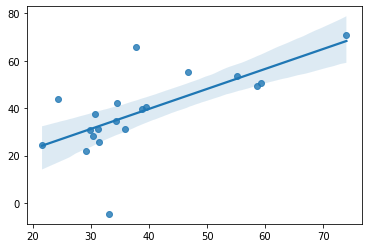

In [50]:
n_sub = 20
p_features = 20

# here we simulate random features - guaranteed to be independent of the target
rng = np.random.default_rng(seed = 42)
df_random = pd.DataFrame(rng.normal(loc=0, scale=1, size=(n_sub, p_features)))

# we load some real age data
age = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv").loc[:n_sub-1,['Age']].values.ravel()

# sweep parameter space
best_preds = None
best_score = -1
for alpha in np.logspace(start=-3, stop=3, num=20, base=10):
    # cross-validation with a Rideg model
    cv_predictions = cross_val_predict(estimator=Ridge(alpha), y=age, X=df_random, cv=LeaveOneOut())
    # see if it's better
    score = np.corrcoef(age, cv_predictions)[0,1]
    if score > best_score:
        best_score = score
        best_preds = cv_predictions

sns.regplot(x=age, y=best_preds)
print('R = ', best_score)

As we have used random features, this is obviously a false result.
Leakage trough hyperparameters can be especially problematic in case of many hyperparameters, low sample sizes and leave-one-out cross-validation.
In other cases (low number and narrow range of hyperparameter values, large sample size) the risk and the degree of this type of leakage might be negligible.

Either way, we should always ensure that leakage can't happen in our machine learning analysis!
As leakage can be sometimes very hard to spot, the real proof of a predictive model is always the fully independent *external* validation, e.g. evaluating model performance on newly acquired data. During the development of a predictive model, cross-validation (sometimes called *internal* validation) is usually only the first step. If a model performs well in internal validation, it is already worth to put efforts into acquiring a new, truely independent dataset for external validation.
The best practice is to publish the predictive model before the acquisition of the new data starts (e.g. with [preregistration](https://www.cos.io/initiatives/prereg)). Such an approach provides a transparent proof that the model performance estimates are unbiased and leakage-free.

:::{note}
Leakage issues in predictive modelling are not neccessary a consequence of malicious research practice. As machine learning is typically deployed in complex scenarios (many features, many alternative preprocessing strategies, many potential analysis choices), leakage can often happen unintentionally and unnoticably.
Being conscious about the danger of leakage and minimizing (and transparently reporting) alternative analysis branches can, together with higher sample sizes, can boost our trust in the cross-validated results, and improve the chances of a successful external validation and a useful, robust, generalizable model.
:::

:::{admonition} Exercise 4.10
:class: tip, dropdown
In both leakage-examples, try increasing sample size. Does it attenuate the effect of leakage?
:::

:::{admonition} Exercise 4.11
:class: tip, dropdown
Think about possible leakage scenarios for your own datasets.
:::